# Fake Review Identification with Unsupervised Learning

This Notebook is for testing our approach with Yelp dataset which has labeled data. We are identifying fake reviews using unsupervised learning and then verifying the labels with yelp labels to check accuracy

In [2]:
import pandas as pd
import numpy as np
from nltk import ngrams
from nltk.tokenize import word_tokenize
import warnings
import nltk
warnings.filterwarnings('ignore')
import xlrd
import sys
#!{sys.executable} -m pip install textstat
import textstat
data = pd.read_excel('D:/capstone/Scrapped_YELP_LABELLED_DATA.xlsx')

In [39]:
data.head(2)

,ReviewId_x,SentimentText,Quantitative_Score,ReviewDate,Label,PropertyID,SiteId,ReviewDate_Original(MM/DD/YYYY),LanguageId
0,1,"Tuba is super laid back, charming and warm. Or...",5,20/11/2018,Genuine,1,2,11/20/2018,1
1,2,What a fantastic find! Me and fiancé love Ista...,5,28/10/2018,Genuine,1,2,10/28/2018,1


In [21]:
data.columns

Index(['ReviewId_x', 'SentimentText', 'Quantitative_Score', 'ReviewDate',
       'Label', 'PropertyID', 'SiteId', 'ReviewDate_Original(MM/DD/YYYY)',
       'LanguageId'],
      dtype='object')

Features Used in  Clusterting model:

'cosine_sim', 'reading_ease', 'property_date_count','QuantitativeScore_x', 'SentimentScore', 'ReviewScore', 'length', 'No_Of_Unique_Words', 'POS_Tags_Nouns',
       'POS_Tags_Verbs', 'deviation',
       'positive_emotion', 'negative_emotion', 'extreme'

In [22]:
data.columns

Index(['ReviewId_x', 'SentimentText', 'Quantitative_Score', 'ReviewDate',
       'Label', 'PropertyID', 'SiteId', 'ReviewDate_Original(MM/DD/YYYY)',
       'LanguageId'],
      dtype='object')

In [23]:
data['SentimentText']=data['SentimentText'].fillna("")
data['text1'] = data['SentimentText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['text1'] = data['text1'].str.replace('[^\w\s]','')
data['bigram'] = data['text1'].apply(lambda row: list(ngrams(word_tokenize(row), 2)))

In [24]:
#Defining cosine similarity 
from collections import Counter
import math
def spell_check2(text):
    return([words for words in text if words not in word_set])
def Counter1(text):
    return(Counter(text.split()))
def cosine_similarity_ngrams(a, b):
    vec1 = Counter(a)
    vec2 = Counter(b)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()]) 
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return float(numerator) / denominator

In [2]:
#calculate cosine similarity of each review with other reviews of same hotel and pick the maximum value of them
eng_review = data
for index, row in eng_review.iterrows():
    x = row["bigram"]
    csf = 0
    nearest = 0
    near_rev = ''
    for index1, row1 in eng_review.iterrows():
        if(int(row["ReviewId_x"]) != int(row1["ReviewId_x"])): 
            cs = cosine_similarity_ngrams(x,row1["bigram"])
            if csf < cs and cs != 1.0:
                csf = cs   
                nearest = row1["ReviewId_x"]
                near_rev = row1["SentimentText"]
    eng_review.at[index, 'cosine_sim'] = csf

In [22]:
#Calculating Reviews received per date and adding it to the dataframe. More reviews in a single day are more suspicious compared to less reviews per day
a = data.groupby(['ReviewDate']).ReviewId_x.count().reset_index()
data = data.merge(a, how='left', on=['ReviewDate'])

In [24]:
data = data.rename({'ReviewId_x_y':'property_date_count'}, axis=1)
data = data.rename({'ReviewId_x_x':'ReviewId_x'}, axis=1)

In [26]:
#Extracting Feature - Length of review
data['length'] = data['SentimentText'].str.len()

In [27]:
#Extracting feature which determines if a review is extreme or not
def detectextreme(a):
    if a == 0.0 or a== 10.0:
        return 1
    else:
        return 0

data['extreme'] = data['Quantitative_Score'].apply(detectextreme)

In [28]:
#Extracting number of unique words in a review
def unique_words(text):
    return len(set(text.split()))
data['No_Of_Unique_Words']= data['text1'].apply(unique_words)

In [29]:
#removing reviews which has length less than 10
data = data.loc[data['length']>10]

In [30]:
#Extracting features which gives count of nouns and verbs in a review
def POS_Tagging_Nouns(sentence):
    tagged_list = []
    tags = []
    count_verbs = 0
    count_nouns = 0
    text=nltk.word_tokenize(sentence)
    tagged_list = (nltk.pos_tag(text))
    tags = [x[1] for x in tagged_list]
    for each_item in tags:
        if each_item in ['VERB','VB','VBN','VBD','VBZ','VBG','VBP']:
            count_verbs+=1
        elif each_item in ['NOUN','NNP','NN','NUM','NNS','NP','NNPS']:
            count_nouns+=1
    return count_nouns

def POS_Tagging_Verbs(sentence):
    tagged_list = []
    tags = []
    count_verbs = 0
    count_nouns = 0
    text=nltk.word_tokenize(sentence)
    tagged_list = (nltk.pos_tag(text))
    
    tags = [x[1] for x in tagged_list]
    for each_item in tags:
        if each_item in ['VERB','VB','VBN','VBD','VBZ','VBG','VBP']:
            count_verbs+=1
        elif each_item in ['NOUN','NNP','NN','NUM','NNS','NP','NNPS']:
            count_nouns+=1
    return count_verbs
if 1==1:
    data['POS_Tags_Nouns']=data['text1'].apply(POS_Tagging_Nouns)
    data['POS_Tags_Verbs']=data['text1'].apply(POS_Tagging_Verbs)

In [32]:
#Using Flesch module to extract readability of a review
def reading_ease(text):
    return textstat.flesch_reading_ease(text)
data['reading_ease'] = data['text1'].apply(reading_ease)

In [44]:
#Extracting feature which gives deviation of a review score from average
a = data['Quantitative_Score'].mean()
data['Quantitative_Score_y'] = a
data['deviation'] = abs(data['Quantitative_Score_y'] - data['Quantitative_Score'])

In [47]:
import sys
!{sys.executable} -m conda install -c conda-forge textblob 
from textblob import TextBlob
data['sentiment'] = data['SentimentText'].apply(lambda x: TextBlob(x).sentiment[0])

Solving environment: ...working... done

# All requested packages already installed.



In [48]:
data.columns

Index(['ReviewId_x', 'SentimentText', 'Quantitative_Score', 'ReviewDate',
       'Label', 'PropertyID', 'SiteId', 'ReviewDate_Original(MM/DD/YYYY)',
       'LanguageId', 'text1', 'bigram', 'cosine_sim', 'property_date_count',
       'length', 'extreme', 'No_Of_Unique_Words', 'POS_Tags_Nouns',
       'POS_Tags_Verbs', 'reading_ease', 'deviation', 'Quantitative_Score_y',
       'sentiment'],
      dtype='object')

In [49]:
#Using Empath package to detect extent of positive emotion and negative emotion in the review.
import sys
!{sys.executable} -m pip install empath
from empath import Empath
lexicon = Empath()
def lex(x):
    lx = lexicon.analyze(x, normalize=True)
    return pd.Series((lx['positive_emotion'],lx['negative_emotion']))
data[['positive_emotion', 'negative_emotion']] = data.apply(lambda row: pd.Series(lex(row['text1'])), axis=1)

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:

data = pd.read_csv('D:/capstone/yelp_model_data.csv')

In [4]:
data.columns

Index(['Unnamed: 0', 'ReviewId_x', 'SentimentText', 'Quantitative_Score',
       'ReviewDate', 'Label', 'PropertyID', 'SiteId',
       'ReviewDate_Original(MM/DD/YYYY)', 'LanguageId', 'text1', 'bigram',
       'cosine_sim', 'property_date_count', 'length', 'extreme',
       'No_Of_Unique_Words', 'POS_Tags_Nouns', 'POS_Tags_Verbs',
       'reading_ease', 'deviation', 'Quantitative_Score_y', 'sentiment',
       'positive_emotion', 'negative_emotion', 'Label1', 'kmeans', 'gmm',
       'db'],
      dtype='object')

In [5]:
data = data.drop(['kmeans', 'gmm', 'db'], axis=1)

In [6]:
df = data[['cosine_sim', 'reading_ease', 'property_date_count','Quantitative_Score', 'sentiment',  'length', 'No_Of_Unique_Words', 'POS_Tags_Nouns',
       'POS_Tags_Verbs', 'deviation',
       'positive_emotion', 'negative_emotion', 'extreme' ]]

In [7]:
#Normalizing the data between 0 and 1. As we will be using Kmeans - which uses Euclidean distance normalizing the data is useful while calculating the distance between datapoints
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(df)

In [9]:
cols = df.columns

In [10]:
#kmeans model 
#data = data.drop(['kmeans'], axis=1)
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)
df = pd.DataFrame(rescaledX, columns=cols)
clust_labels, cent = doKmeans(df, 2)
kmeans = pd.DataFrame(clust_labels)
df.insert((df.shape[1]),'kmeans',kmeans)
data.insert((data.shape[1]),'kmeans',kmeans)

In [11]:
data['kmeans'].value_counts()

0    907
1    150
Name: kmeans, dtype: int64

In [12]:
def principal_component_analysis(x_train):
    # Extract the variable to be predicted
    y_train = x_train["gmmnc"]
    x_train = x_train.drop(labels="gmmnc", axis=1)
    classes = np.sort(np.unique(y_train))
    labels = ["Fake Review", "Non- Fake review"]
    
    # Normalize each feature to unit norm (vector length)
    x_train_normalized = normalize(x_train, axis=0)
    
    # Run PCA
    pca = PCA(n_components=2)
    x_train_projected = pca.fit_transform(x_train_normalized)

    # Visualize
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    colors = [(0.0, 0.63, 0.69), 'black']
    markers = ["o", "D"]
    for class_ix, marker, color, label in zip(
            classes, markers, colors, labels):
        ax.scatter(x_train_projected[np.where(y_train == class_ix), 0],
                   x_train_projected[np.where(y_train == class_ix), 1],
                   marker=marker, color=color, edgecolor='whitesmoke',
                   linewidth='1', alpha=0.9, label=label)
        ax.legend(loc='best')
    plt.title(
        "Scatter plot of the training data examples projected on the "
        "2 first principal components with diagonal covariance")
    plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
    plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))
    plt.show()

    plt.savefig("pca.pdf", format='pdf')
    plt.savefig("pca.png", format='png')


def remove_feat_constants(data_frame):
    print("")
    print("Deleting zero variance features...")
    n_features_originally = data_frame.shape[1]
    selector = VarianceThreshold()
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
    orig_feat_ix = np.arange(data_frame.columns.size)
    feat_ix_delete = np.delete(orig_feat_ix, feat_ix_keep)
    # Delete zero variance feats from the original pandas data frame
    data_frame = data_frame.drop(labels=data_frame.columns[feat_ix_delete],
                                 axis=1)
    # Print info
    n_features_deleted = feat_ix_delete.size
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    return data_frame


def remove_feat_identicals(data_frame):
    # Find feature vectors having the same values in the same order and
    # remove all but one of those redundant features.
    print("")
    print("Deleting identical features...")
    n_features_originally = data_frame.shape[1]
    # Find the names of identical features by going through all the
    # combinations of features (each pair is compared only once).
    feat_names_delete = []
    for feat_1, feat_2 in itertools.combinations(
            iterable=data_frame.columns, r=2):
        if np.array_equal(data_frame[feat_1], data_frame[feat_2]):
            feat_names_delete.append(feat_2)
    feat_names_delete = np.unique(feat_names_delete)
    # Delete the identical features
    data_frame = data_frame.drop(labels=feat_names_delete, axis=1)
    n_features_deleted = len(feat_names_delete)
    print("  - Deleted %s / %s features (~= %.1f %%)" % (
        n_features_deleted, n_features_originally,
        100.0 * (np.float(n_features_deleted) / n_features_originally)))
    return data_frame



Deleting zero variance features...
  - Deleted 1 / 14 features (~= 7.1 %)

Deleting identical features...
  - Deleted 0 / 13 features (~= 0.0 %)


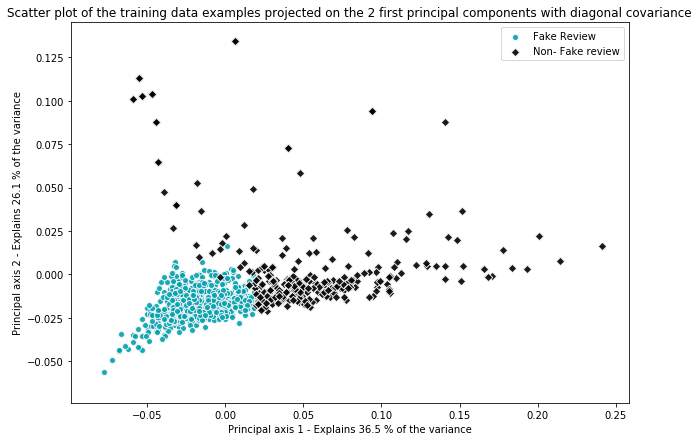

<Figure size 432x288 with 0 Axes>

In [123]:
import itertools
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
x_train = df2
#x_train = pd.read_csv(filepath_or_buffer="../input/train.csv",index_col=0, sep=',')
x_train = remove_feat_constants(x_train)
x_train = remove_feat_identicals(x_train)
principal_component_analysis(x_train)

In [31]:
#Get Count of reviews in each cluster
df['kmeans'].value_counts()

1    906
0    151
Name: kmeans, dtype: int64

In [90]:
df1 = data[['cosine_sim', 'reading_ease', 'property_date_count','Quantitative_Score', 'sentiment',  'length', 'No_Of_Unique_Words', 'POS_Tags_Nouns',
       'POS_Tags_Verbs', 'deviation',
       'positive_emotion', 'negative_emotion', 'extreme' ]]

In [91]:
cols1 = df1.columns

In [92]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX1 = scaler.fit_transform(df1)

In [94]:
#Gaussian Mixture Model with Full Covariance
data = data.drop('gmm', axis=1)
from sklearn.mixture import GMM
def doGmm(X, nclust=2):
    model = GMM(nclust, covariance_type='full')
    model.fit(X)
    clust_labels = model.predict(X)
    #cent = model.cluster_centers_
    return (clust_labels)

df1 = pd.DataFrame(rescaledX1, columns=cols1)
clust_labels = doGmm(df1, 2)
gmm = pd.DataFrame(clust_labels)
df1.insert((df1.shape[1]),'gmm',gmm)
data.insert((data.shape[1]), 'gmm', gmm)

In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(data['Label1'], data['gmm'])

0.8694418164616841

In [96]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data['Label1'], data['gmm'])

array([[789, 138],
       [  0, 130]], dtype=int64)

In [41]:
df2 = data[['cosine_sim', 'reading_ease', 'property_date_count','Quantitative_Score', 'sentiment',  'length', 'No_Of_Unique_Words', 'POS_Tags_Nouns',
       'POS_Tags_Verbs', 'deviation',
       'positive_emotion', 'negative_emotion', 'extreme' ]]

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX2 = scaler.fit_transform(df2)

In [46]:

from sklearn.mixture import GMM
#data = data.drop('gmmnc', axis=1)
df2 = df2.drop('gmmnc', axis=1)
cols = df2.columns
def doGmm(X, nclust=2):
    model = GMM(nclust, covariance_type = 'full')
    model.fit(X)
    clust_labels = model.predict(X)
    #cent = model.cluster_centers_
    return (clust_labels)

df2 = pd.DataFrame(rescaledX2, columns=cols)
clust_labels = doGmm(df2, 2)
gmm = pd.DataFrame(clust_labels)
df2.insert((df2.shape[1]),'gmmnc',gmm)
data.insert((data.shape[1]),'gmmnc',gmm)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(data['Label1'], data['gmmnc'])

0.8694418164616841

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data['Label1'], data['gmmnc'])

array([[681, 246],
       [  0, 130]], dtype=int64)

In [124]:
data['gmm'].value_counts()

0    789
1    268
Name: gmm, dtype: int64

In [125]:
data['gmmnc'].value_counts()

0    681
1    376
Name: gmmnc, dtype: int64

In [126]:
data['kmeans'].value_counts()

0    907
1    150
Name: kmeans, dtype: int64

In [86]:
#Yelp Provided labels
data['Label'].value_counts()

Genuine    927
FAKE       130
Name: Label, dtype: int64

In [57]:
#labels provided by Yelp which we are using here to test our model
def labeldef(a):
    if a == 'Genuine':
        return 0
    else:
        return 1

In [58]:
data['Label1'] = data['Label'].apply(labeldef)

In [35]:
df.head(2)

,cosine_sim,reading_ease,property_date_count,Quantitative_Score,sentiment,No_Of_Unique_Words,deviation,positive_emotion,negative_emotion,extreme,kmeans
0,0.070167,0.882530,0.000000,1.0,0.483397,0.165165,0.283507,0.000000,0.0,0.0,1
1,0.121156,0.801147,0.071429,1.0,0.474576,0.249249,0.283507,0.142857,0.0,0.0,1


In [34]:
#adding Kmeans and Gmm model predicted labels to original dataset
data.insert((data.shape[1]),'kmeans',kmeans)
data.insert((data.shape[1]),'gmm',gmm)
data.insert((data.shape[1]),'db',dbd)

ValueError: cannot insert kmeans, already exists

In [99]:
data[['Label1', 'kmeans', 'gmm', 'db']].head(10)

,Label1,kmeans,gmm,db
0,0,0,0,-1
1,0,0,0,-1
2,0,0,0,-1
3,0,0,0,-1
4,0,0,0,-1
5,0,0,0,-1
6,0,0,1,-1
7,0,0,1,-1
8,0,0,0,-1
9,0,0,1,-1


In [121]:
#predicted labels for Kmeans model for Yelp dataset
data['kmeans'].value_counts()

0    907
1    150
Name: kmeans, dtype: int64

In [122]:
#Predicted labels for GMM for Yelp Dataset
data['gmm'].value_counts()

0    789
1    268
Name: gmm, dtype: int64

In [14]:
#Calculating accuracy Score for Actual labels and Kmeans predicted labels
from sklearn.metrics import accuracy_score
accuracy_score(data['Label1'], data['kmeans'])

0.9810785241248817

In [50]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(data['Label1'], data['kmeans'])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.9892125134843581

Text(0.5,0,'False Positive Rate')

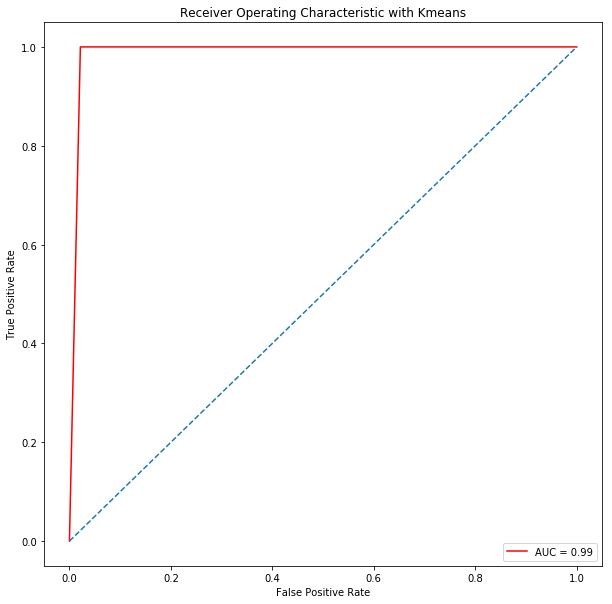

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic with Kmeans')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [66]:
df.head(2)

,cosine_sim,reading_ease,property_date_count,Quantitative_Score,sentiment,No_Of_Unique_Words,deviation,positive_emotion,negative_emotion,extreme,kmeans
0,0.070167,0.882530,0.000000,1.0,0.483397,0.165165,0.283507,0.000000,0.0,0.0,1
1,0.121156,0.801147,0.071429,1.0,0.474576,0.249249,0.283507,0.142857,0.0,0.0,1


In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data['Label1'], data['kmeans'])

array([[907,  20],
       [  0, 130]], dtype=int64)

In [37]:
#checking number of labels matched between acutal and Kmeans predicted labels
matched = 0
unmatched = 0
for index, row in data.iterrows():
   if int(row['Label1']) == int(row['kmeans']):
      matched = matched + 1
   else:
      unmatched = unmatched + 1
   
print('matched labels:', matched, 'unmatched labels:', unmatched )    

matched labels: 1037 unmatched labels: 20


In [126]:
#checking number of labels matched between acutal and gmm predicted labels
matched = 0
unmatched = 0
for index, row in data.iterrows():
   if int(row['Label1']) == int(row['gmm']):
      matched = matched + 1
   else:
      unmatched = unmatched + 1
   
print('matched labels:', matched , 'unmatched labels:', unmatched)    

matched labels: 919 unmatched labels: 138


In [123]:
data.to_csv('yelp_model_data.csv')

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

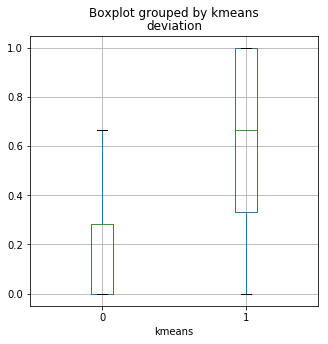

In [13]:
df.boxplot(column=['deviation'], by='kmeans', figsize = (5,5))